In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import os

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
generator = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
print(len(train_dataset), len(valid_dataset), len(test_dataset))

from collections import Counter
print(Counter(train_dataset.dataset.targets))

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [59]:
class Noscheduler:
    def __init__(self, lr=0.001):
        self.lr = lr
    @staticmethod
    def step():
        pass
    def get_last_lr(self):
        return [self.lr]
    
def prepare_training(scheduler='OneCycleLR', 
                     epochs=20, 
                     batch_size=128,
                     lr=0.001, 
                     max_lr=0.01, 
                     end_lr=0.0001, 
                     num_workers=2, 
                     num_classes=10):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = models.resnet50(weights=None, num_classes=num_classes) 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if scheduler==None:
        scheduler = Noscheduler(lr=lr)
    elif scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=epochs)
    elif scheduler=='LinearLR':
        scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=end_lr/lr, total_iters=epochs*len(train_loader))


    return train_loader, valid_loader, test_loader, model, device, criterion, optimizer, scheduler

Using scheduler: LinearLR


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

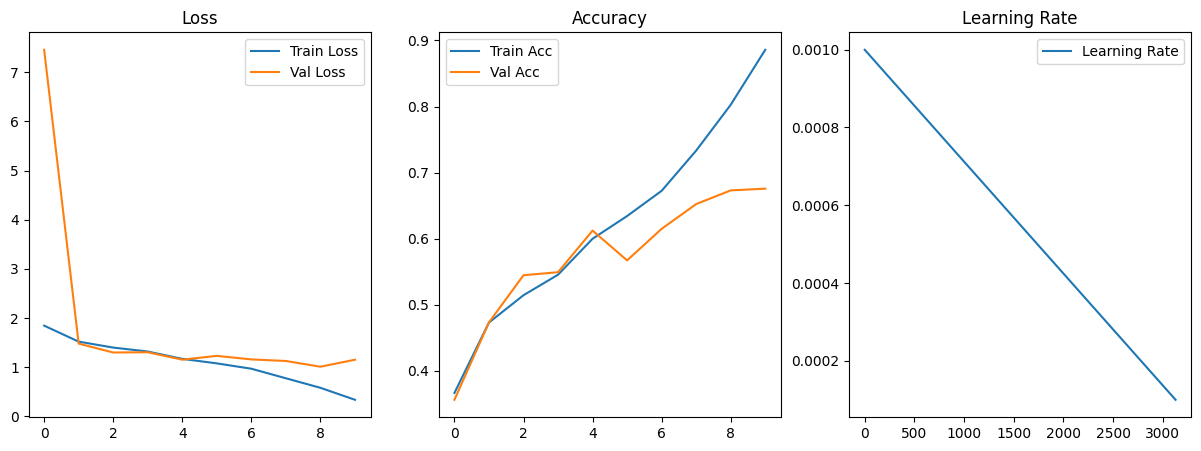

Model accuracy on 10000 test images: 68%
Using scheduler: None


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

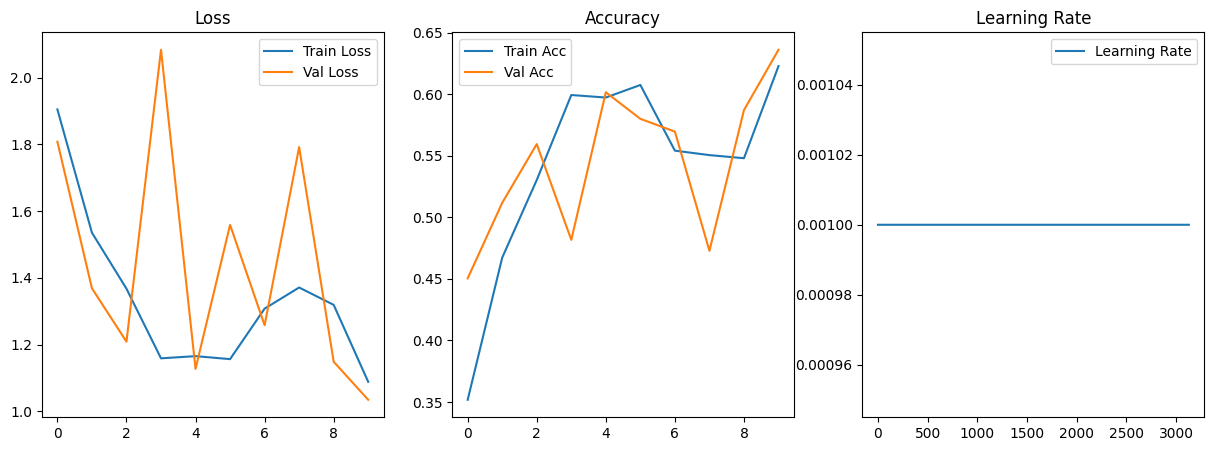

Model accuracy on 10000 test images: 62%
Using scheduler: OneCycleLR


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

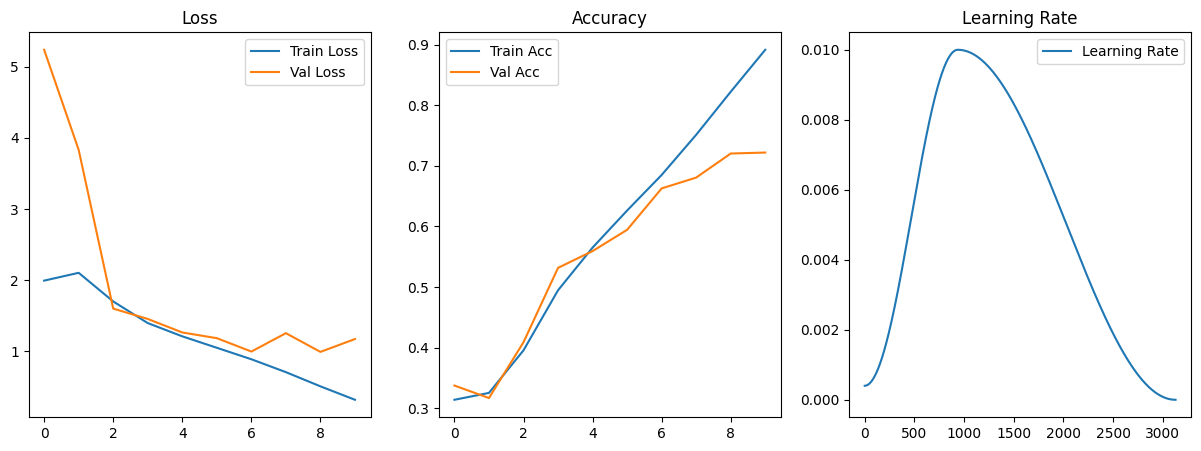

Model accuracy on 10000 test images: 72%


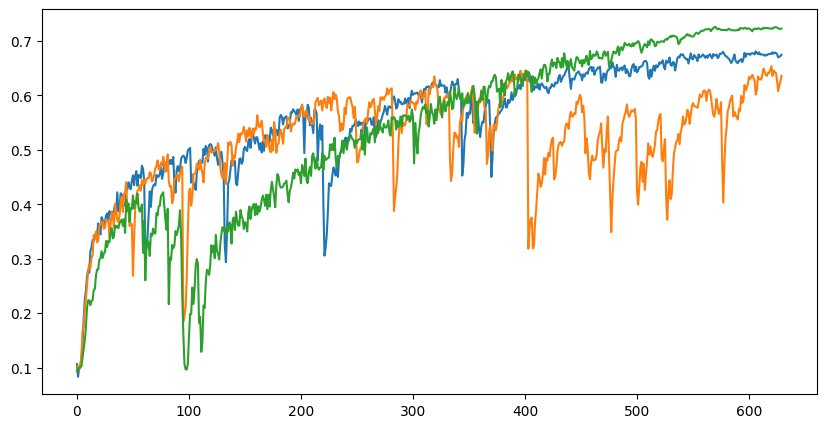

In [62]:

from torch.cuda.amp import GradScaler, autocast 
from tqdm.auto import tqdm 

epochs = 10
lr = 0.001
max_lr = 0.01

exp_list = ['LinearLR', None, 'OneCycleLR']
# [None, 'OneCycleLR']
all_val_step_dict = {}
for scheduler_type in exp_list:
    print(f'Using scheduler: {scheduler_type}')
    train_loader, valid_loader, test_loader, model,\
        device, criterion, optimizer, scheduler = \
            prepare_training(scheduler_type, epochs=epochs, lr=lr, max_lr=max_lr)
    metric_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_step_loss': [],
        'val_step_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    scaler = GradScaler()
    best_val_accuracy = 0
    for epoch in (tqdm_bar := tqdm(range(epochs))):
        model.train()

        desc = f'Epoch {epoch+1}/{epochs}, '
        running_loss = 0.0
        total_correct = 0
        total_images = 0
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()


            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scheduler.step()
            metric_dict['lr'].append(scheduler.get_last_lr()[0])

            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # Validation phase
            if i % 5 == 0:
                model.eval()
                val_running_loss = 0.0
                val_total_correct = 0
                val_total_images = 0
                with torch.no_grad():
                    for i, data in enumerate(valid_loader):
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        val_running_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total_images += labels.size(0)
                        val_total_correct += (predicted == labels).sum().item()
                    current_val_accuracy = val_total_correct / val_total_images                
                    metric_dict['val_step_loss'].append(val_running_loss/(i+1))
                    metric_dict['val_step_acc'].append(current_val_accuracy)
            model.train()
        

        desc += f'Train Loss: {running_loss/(i+1):.3f}, Train Acc: {total_correct/total_images:.3f}, '
        metric_dict['train_loss'].append(running_loss/(i+1))
        metric_dict['train_acc'].append(total_correct/total_images)


        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_total_correct = 0
        val_total_images = 0
        with torch.no_grad():
            for i, data in enumerate(valid_loader):
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total_images += labels.size(0)
                val_total_correct += (predicted == labels).sum().item()
            current_val_accuracy = val_total_correct / val_total_images
            metric_dict['val_loss'].append(val_running_loss/(i+1))
            metric_dict['val_acc'].append(current_val_accuracy)
        model.train()
        

        

        desc += f'Val Loss: {val_running_loss/(i+1):.3f}, Val Acc: {current_val_accuracy:.3f}'
        

        tqdm_bar.set_description(desc)

        # Update the best model if current validation accuracy is better
        if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy
            os.makedirs(f'./checkpoints/{scheduler_type}', exist_ok=True)
            torch.save(model.state_dict(), f'./checkpoints/{scheduler_type}/best_model.pth')
            
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(metric_dict['train_loss'], label='Train Loss')
    ax[0].plot(metric_dict['val_loss'], label='Val Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(metric_dict['train_acc'], label='Train Acc')
    ax[1].plot(metric_dict['val_acc'], label='Val Acc')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    ax[2].plot(metric_dict['lr'], label='Learning Rate')
    ax[2].set_title('Learning Rate')
    ax[2].legend()
    plt.savefig(f'./plots/{scheduler_type}.png')
    plt.show()

    all_val_step_dict[scheduler_type] = metric_dict['val_step_acc']

    model.eval()
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    print('Model accuracy on 10000 test images: %d%%' % (total_correct * 100 / total_images))

import json
with open('results.json', 'w') as f:
    json.dump(all_val_step_dict, f)

results_dict = json.load(open('results.json', 'r'))
figure = plt.figure(figsize=(10, 5), dpi=200)
for key, val in results_dict.items():
    plt.plot(val, label=key, linewidth=0.6)
plt.legend()
plt.show()

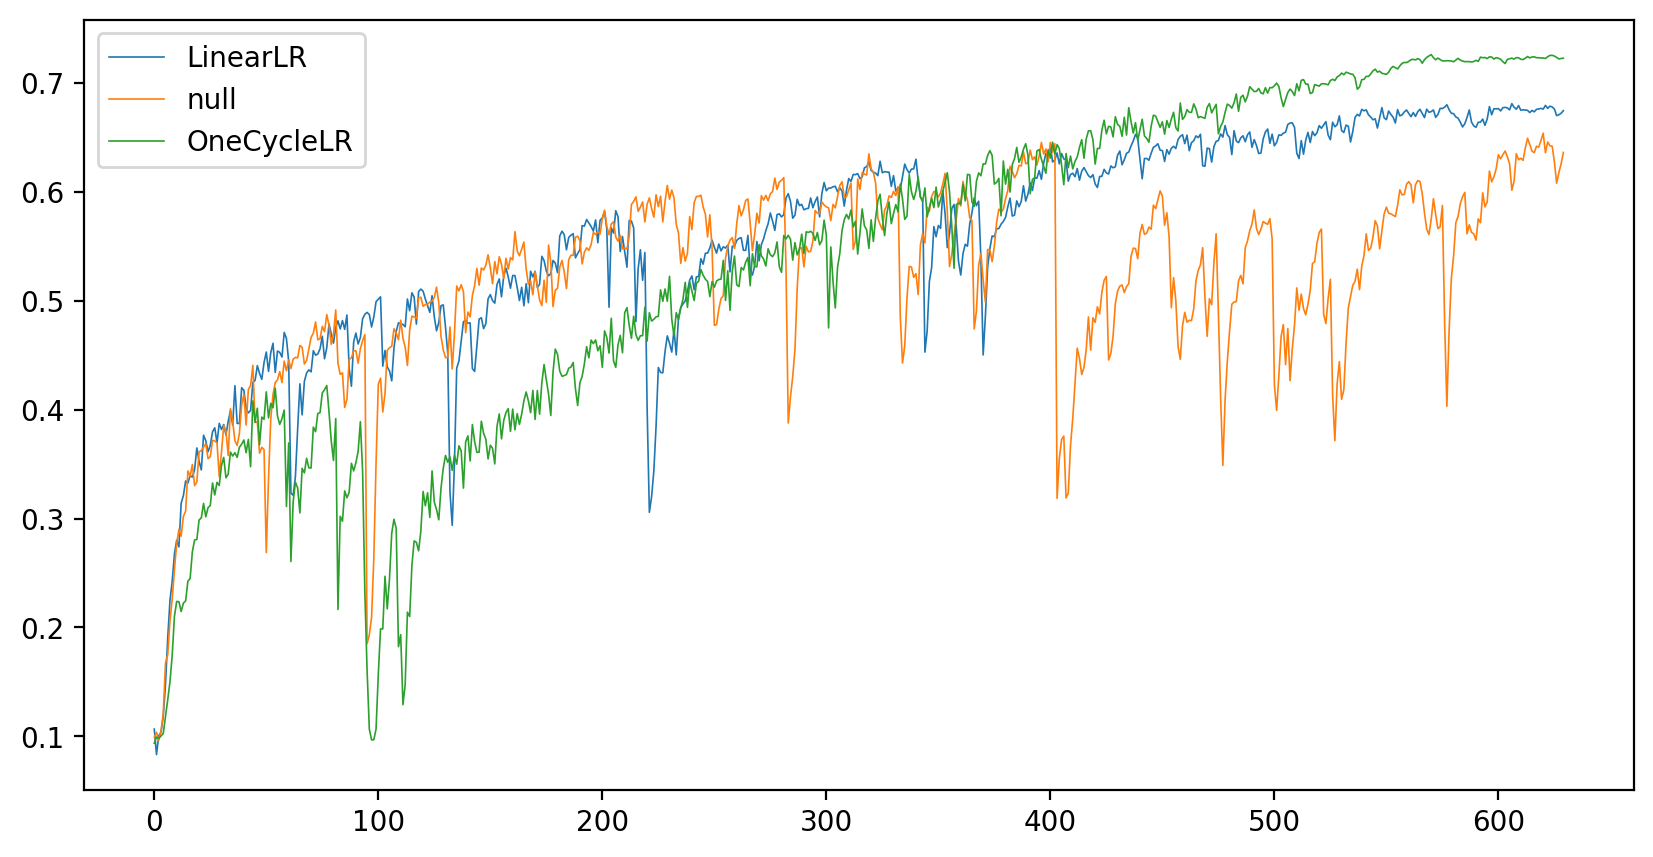